# 2. Análisis de audios como datos brutos

Se usa el set A del dataset Heartbeat Sounds de Kaggle. El conjunto de entradas corresponde a archivos de audio de latidos de corazón, y la salida esperada es una de 4 categorías: 1. Normal, 2. Murmur, 3. Extra Heart Sound y 4. Artifact. Esta información está contenida en el archivo CSV set_a.csv. Es posible que existan audios sin etiqueta asignada, por lo que se ignorarán. El objetivo de la actividad es diseñar una máquina que aprenda a determinar la categoría correcta para futuras entradas de sonido de latidos de corazón.

In [1]:
from scipy.io import wavfile

def clean_filename(fname, string):
    file_name = fname.split('/')[1]
    if file_name[:2] == '__':
        file_name=string + file_name
    return file_name

SAMPLE_RATE = 44100

def load_wav_file(name, path):
    s, b = wavfile.read(path+name)
    assert s == SAMPLE_RATE
    return b

#### (a) Se construye dataframe con los datos a usar.

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('./heartbeat-sounds/set_a.csv')

In [3]:
df.head(10)

,dataset,fname,label,sublabel
0,a,set_a/artifact__201012172012.wav,artifact,NaN
1,a,set_a/artifact__201105040918.wav,artifact,NaN
2,a,set_a/artifact__201105041959.wav,artifact,NaN
3,a,set_a/artifact__201105051017.wav,artifact,NaN
4,a,set_a/artifact__201105060108.wav,artifact,NaN
5,a,set_a/artifact__201105061143.wav,artifact,NaN
6,a,set_a/artifact__201105190800.wav,artifact,NaN
7,a,set_a/artifact__201105280851.wav,artifact,NaN
8,a,set_a/artifact__201106010559.wav,artifact,NaN
9,a,set_a/artifact__201106010602.wav,artifact,NaN


Una inspección manual sobre el dataset permite confirmar que existen 176 registros de audio, de los cuales sólo los primeros 124 se encuentran etiquetados. De éstos, hay 40 calificados como 'Artifact', 19 como 'extrahls', 34 como 'murmur' y 31 como 'normal'. Durante el ejercicio, no se usarán las columnas 'set' ni 'sublabel', por lo que se eliminarán del dataframe.

In [4]:
df = df.drop(['dataset','sublabel'], axis=1)

In [5]:
df.head(10)

,fname,label
0,set_a/artifact__201012172012.wav,artifact
1,set_a/artifact__201105040918.wav,artifact
2,set_a/artifact__201105041959.wav,artifact
3,set_a/artifact__201105051017.wav,artifact
4,set_a/artifact__201105060108.wav,artifact
5,set_a/artifact__201105061143.wav,artifact
6,set_a/artifact__201105190800.wav,artifact
7,set_a/artifact__201105280851.wav,artifact
8,set_a/artifact__201106010559.wav,artifact
9,set_a/artifact__201106010602.wav,artifact


#### (b) Lectura de los archivos de audio de entrada

Se cargan los archivos enlistados en el el dataframe filtrado resultante en (a). Se realiza un padding de ceros a cada archivo, de manera que todos tengan la misma duración que el más largo. De no hacer esto, la distinta duración se traduce en que se conforman por distintas cantidades de elementos o atributos. Esto significa que, sin padding, cada archivo de entrada tendría una dimensionalidad distinta, lo que no es aceptable por ningún método de aprendizaje automático visto en el curso.

In [6]:
def padd_zeros(array,length):
    aux = np.zeros(length)
    aux[:array.shape[0]] = array
    return aux

new_df = pd.DataFrame({'file_name' : df['fname'].apply(clean_filename,string='Aunlabelledtest')})
new_df['time_series'] = new_df['file_name'].apply(load_wav_file, path='./heartbeat-sounds/set_a/')
new_df['len_series'] = new_df['time_series'].apply(len)
new_df['time_series']=new_df['time_series'].apply(padd_zeros,length=max(new_df['len_series']))

In [7]:
new_df.head(10)

,file_name,time_series,len_series
0,artifact__201012172012.wav,"[1.0, -3.0, -1.0, -7.0, -9.0, -2.0, -6.0, -5.0...",396900
1,artifact__201105040918.wav,"[-2.0, 3.0, -4.0, 4.0, -3.0, 2.0, -1.0, 0.0, 0...",396900
2,artifact__201105041959.wav,"[6.0, -4.0, -9.0, -1.0, -4.0, 1.0, -5.0, 2.0, ...",396900
3,artifact__201105051017.wav,"[-85.0, -198.0, -214.0, -173.0, -177.0, -206.0...",396900
4,artifact__201105060108.wav,"[53.0, -35.0, 47.0, 170.0, 340.0, 436.0, 535.0...",396900
5,artifact__201105061143.wav,"[-2.0, 2.0, -2.0, 2.0, -2.0, 1.0, 1.0, -3.0, 3...",396900
6,artifact__201105190800.wav,"[47.0, 70.0, 47.0, 58.0, 53.0, 45.0, 13.0, 21....",396900
7,artifact__201105280851.wav,"[605.0, 648.0, 473.0, 171.0, -203.0, -512.0, -...",396900
8,artifact__201106010559.wav,"[-49.0, 0.0, 17.0, -43.0, 30.0, 9.0, -29.0, 50...",396900
9,artifact__201106010602.wav,"[52.0, -1291.0, -1116.0, 101.0, 2429.0, 3776.0...",396900


#### (c) Reasignación de etiquetas a cada dato

In [8]:
new_labels =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
            1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2,
            2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1,
            1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 0,
            2, 2, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0,
            0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
labels = ['artifact','normal/extrahls', 'murmur']
new_df['target'] = [labels[i] for i in new_labels]

In [9]:
new_df.head(10)

,file_name,time_series,len_series,target
0,artifact__201012172012.wav,"[1.0, -3.0, -1.0, -7.0, -9.0, -2.0, -6.0, -5.0...",396900,artifact
1,artifact__201105040918.wav,"[-2.0, 3.0, -4.0, 4.0, -3.0, 2.0, -1.0, 0.0, 0...",396900,artifact
2,artifact__201105041959.wav,"[6.0, -4.0, -9.0, -1.0, -4.0, 1.0, -5.0, 2.0, ...",396900,artifact
3,artifact__201105051017.wav,"[-85.0, -198.0, -214.0, -173.0, -177.0, -206.0...",396900,artifact
4,artifact__201105060108.wav,"[53.0, -35.0, 47.0, 170.0, 340.0, 436.0, 535.0...",396900,artifact
5,artifact__201105061143.wav,"[-2.0, 2.0, -2.0, 2.0, -2.0, 1.0, 1.0, -3.0, 3...",396900,artifact
6,artifact__201105190800.wav,"[47.0, 70.0, 47.0, 58.0, 53.0, 45.0, 13.0, 21....",396900,artifact
7,artifact__201105280851.wav,"[605.0, 648.0, 473.0, 171.0, -203.0, -512.0, -...",396900,artifact
8,artifact__201106010559.wav,"[-49.0, 0.0, 17.0, -43.0, 30.0, 9.0, -29.0, 50...",396900,artifact
9,artifact__201106010602.wav,"[52.0, -1291.0, -1116.0, 101.0, 2429.0, 3776.0...",396900,artifact


In [10]:
artifact=0
normextra=0
murmur=0
for label in new_labels:
    if label==0:
        artifact+=1
    elif label==1:
        normextra+=1
    elif label==2:
        murmur+=1
print ("Cantidad Artifact:", artifact)
print ("Cantidad normal/extrahls:", normextra)
print ("Cantidad Murmur:", murmur)

Cantidad Artifact: 58
Cantidad normal/extrahls: 65
Cantidad Murmur: 53


La existencia de 3 clases es porque se fusionó 'normal' y 'extrahls'. Los datos a priori mal etiquetados afectan negativamente la calidad predictiva de los modelos que se entrenen con ellos. Con datos mal etiquetados, el modelo aprenderá características que en realidad no corresponden a la clase correcta, por lo que tenderá con mayor probabilidad a confundir datos de la clase real y aquella a la cual de verdad pertenece el dato mal etiquetado. Dependiendo del tipo de modelo y de la cantidad de datos de entrenamiento (bien etiquetados), un solo dato mal etiquetado podría o no afectar la calidad predictiva.

#### (d) Codificación de etiquetas a forma numérica para poder ser procesados por los algoritmos clasificadores

In [11]:
new_df["target"] = new_df["target"].astype('category')
cat_columns = new_df.select_dtypes(['category']).columns
new_df[cat_columns] = new_df[cat_columns].apply(lambda x: x.cat.codes)

In [12]:
new_df.head(10)

,file_name,time_series,len_series,target
0,artifact__201012172012.wav,"[1.0, -3.0, -1.0, -7.0, -9.0, -2.0, -6.0, -5.0...",396900,0
1,artifact__201105040918.wav,"[-2.0, 3.0, -4.0, 4.0, -3.0, 2.0, -1.0, 0.0, 0...",396900,0
2,artifact__201105041959.wav,"[6.0, -4.0, -9.0, -1.0, -4.0, 1.0, -5.0, 2.0, ...",396900,0
3,artifact__201105051017.wav,"[-85.0, -198.0, -214.0, -173.0, -177.0, -206.0...",396900,0
4,artifact__201105060108.wav,"[53.0, -35.0, 47.0, 170.0, 340.0, 436.0, 535.0...",396900,0
5,artifact__201105061143.wav,"[-2.0, 2.0, -2.0, 2.0, -2.0, 1.0, 1.0, -3.0, 3...",396900,0
6,artifact__201105190800.wav,"[47.0, 70.0, 47.0, 58.0, 53.0, 45.0, 13.0, 21....",396900,0
7,artifact__201105280851.wav,"[605.0, 648.0, 473.0, 171.0, -203.0, -512.0, -...",396900,0
8,artifact__201106010559.wav,"[-49.0, 0.0, 17.0, -43.0, 30.0, 9.0, -29.0, 50...",396900,0
9,artifact__201106010602.wav,"[52.0, -1291.0, -1116.0, 101.0, 2429.0, 3776.0...",396900,0


#### (e) Ordenamiento aleatorio de los datos de entrenamiento. Creación de matriz de datos de entrenamiento 'X', y vector de etiquetas 'y'.

In [13]:
new_df = new_df.sample(frac=1,random_state=44)
X = np.stack(new_df['time_series'].values, axis=0)
y = new_df.target.values
X.shape

(176, 396900)

#### (f) Apliación de Transformada de Fourier discreta a las series de tiempo del conjunto de datos de entrenamiento 'X'.

In [14]:
X_fourier = np.abs(np.fft.fft(X))

In [15]:
# este bloque de código asume que cada dato en X está con 
# padding de ceros para que todos tengan la misma longitud

n = X.shape[1] #largo de la señal
t = float(n)/SAMPLE_RATE # duracion de la señal
t_vector = np.arange(0, t, 1.0/SAMPLE_RATE)
freq = np.arange(n)/t

freq = freq[:int(n/2)]

X_fourier_grafico = X_fourier[0][:int(n/2)]
X_fourier_grafico = X_fourier_grafico/n

In [16]:
freq.shape

(198450,)

In [17]:
X_fourier_grafico.shape

(198450,)

In [18]:
X_fourier_grafico[100]

1.3984300333064126

Se compara la 'forma' de cada dato antes y después de la transformación.

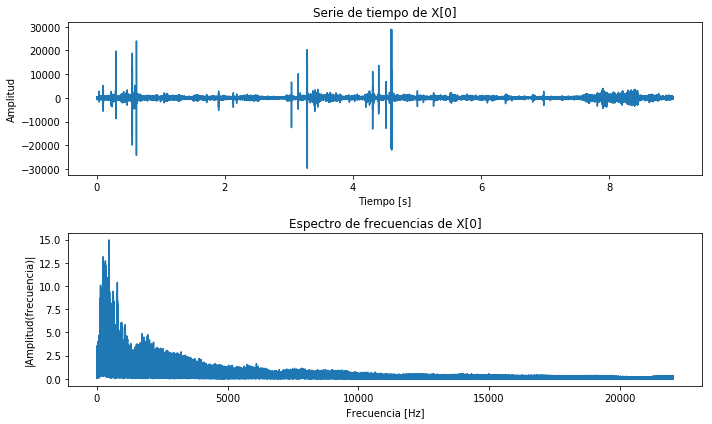

In [19]:
import matplotlib.pyplot as plt

plt.clf()

f, axarr = plt.subplots(2, figsize=(10,6))
axarr[0].plot(t_vector, X[0])
axarr[0].set_title('Serie de tiempo de X[0]')
axarr[0].set_xlabel('Tiempo [s]')
axarr[0].set_ylabel('Amplitud')
axarr[1].plot(freq, X_fourier_grafico)
axarr[1].set_title('Espectro de frecuencias de X[0]')
axarr[1].set_xlabel('Frecuencia [Hz]')
axarr[1].set_ylabel('|Amplitud(frecuencia)|')

plt.tight_layout()

plt.show()

#### (g) Generación de una muestra a partir de los datos de espectros de frecuencias.

El efecto de la ejecución del siguiente bloque de código es que la dimensionalidad de cada dato de entrenamiento se reducirá desde 396900 a sólo 100000. El beneficio de esto, es que la rapidez de ejecución de los algoritmos de aprendizaje será mayor pues se procesará aproximadamente sólo un cuarto de los datos originales. La efectividad del aprendizaje no se verá tan afectada si se logra un muestreo que tenga una distribución lo más parecida posible a la original.

In [20]:
from scipy import signal

X_resampled = []

for i in range(X_fourier.shape[0]):
    sequence = X_fourier[i,:].copy()
    resampled_sequence = signal.resample(sequence, 100000)
    X_resampled.append(resampled_sequence)
    
X_resampled = np.array(X_resampled)
X_resampled.shape

(176, 100000)

#### (h) Se divide el conjunto de datos muestreados en conjunto de entrenamiento y de pruebas.

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_resampled, 
                                                    y, 
                                                    test_size=0.25,
                                                    random_state=42)

In [22]:
print ("Cantidad de datos de entrenamiento:", X_train.shape[0])
print ("Cantidad de datos de prueba:", X_test.shape[0])

Cantidad de datos de entrenamiento: 132
Cantidad de datos de prueba: 44


#### (i) Estandarización del conjunto de datos de entrada (entrenamiento y pruebas)

Se centran y escalan los datos usando la media y la desviación estándar de los datos de ETRENAMIENTO.

In [23]:
from sklearn.preprocessing import StandardScaler

std = StandardScaler(with_mean=True, with_std=True)
std.fit(X_train)
X_train = std.transform(X_train)
X_test = std.transform(X_test)

#### (j) Uso de PCA para reducción de dimensionalidad a d=2 dimensiones. Visualización de la proyección generada.

Se genera una proyección en dos dimensiones de los conjuntos de entrenamiento y prueba.

In [24]:
from sklearn.decomposition import PCA

d=2
pca_model = PCA(n_components=d)
pca_model.fit(X_train)
X_pca_train = pca_model.transform(X_train)
X_pca_test = pca_model.transform(X_test)

In [25]:
X_pca_train.shape

(132, 2)

In [26]:
X_pca_train[0]

array([-44.97739475, -15.03221551])

Se visualizan los conjuntos proyectados. Los colores de los puntos se corresponden con la clase de cada uno:


0: 'artifact' -> Rojo

1: 'normal/extrahls' -> Verde

2: 'murmur' -> Azul

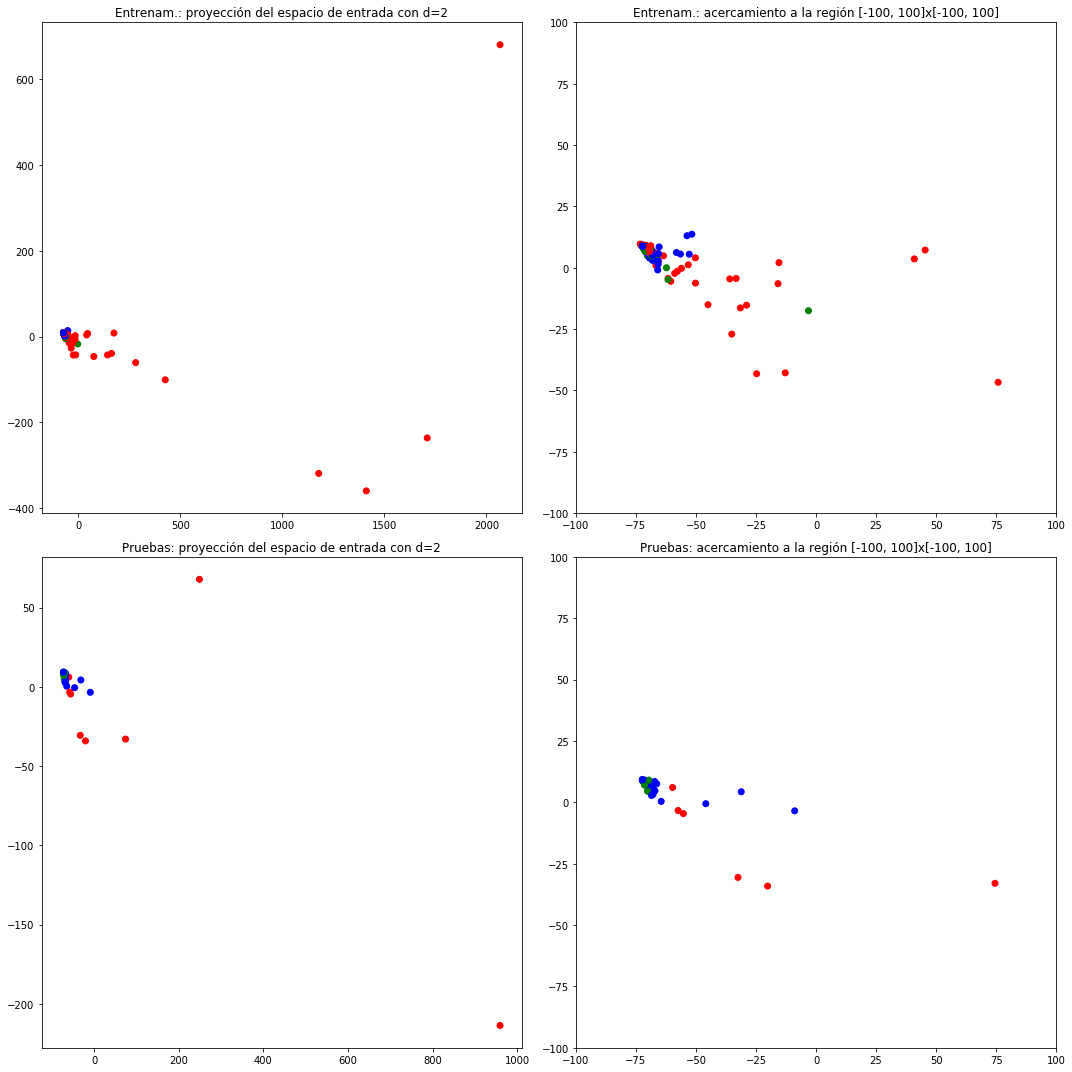

In [27]:
color = {0: "r", 1: "g", 2: "b"}
colores_train = [color[i] for i in y_train]
colores_test = [color[i] for i in y_test]

plt.clf()

f, axarr = plt.subplots(2, 2, figsize=(15,15))
axarr[0][0].scatter(X_pca_train.T[0], X_pca_train.T[1], c=colores_train)
axarr[0][0].set_title('Entrenam.: proyección del espacio de entrada con d=2')
axarr[0][1].scatter(X_pca_train.T[0], X_pca_train.T[1], c=colores_train)
axarr[0][1].set_xlim([-100, 100])
axarr[0][1].set_ylim([-100, 100])
axarr[0][1].set_title('Entrenam.: acercamiento a la región [-100, 100]x[-100, 100]')
axarr[1][0].scatter(X_pca_test.T[0], X_pca_test.T[1], c=colores_test)
axarr[1][0].set_title('Pruebas: proyección del espacio de entrada con d=2')
axarr[1][1].scatter(X_pca_test.T[0], X_pca_test.T[1], c=colores_test)
axarr[1][1].set_xlim([-100, 100])
axarr[1][1].set_ylim([-100, 100])
axarr[1][1].set_title('Pruebas: acercamiento a la región [-100, 100]x[-100, 100]')

plt.tight_layout()

plt.show()

Las clases no se separan tan explicitamente en el espacio proyectado. Las causas de esto son variadas, pero es posible que el factor más influyente sea la dependencia lineal entre los atributos. Al tratarse de espectros de frecuencia, éstos tienden a ser continuos, por lo que el valor del espectro en determinado punto influirá directamente en el valor del espectro en su vecindad. 

#### (k) Entrenamiento de modelo de Regresión Logística con parámetro de regularización C varible. Entrenamiento de Máquina de Vectores de Soporte de kernel lineal, con parámetro de regularización C variable.

In [28]:
def visualize_border(model,x,y,title=""):
    fig = plt.figure(figsize=(16,8))
    plt.scatter(x[:,0], x[:,1], s=50, c=y, cmap=plt.cm.winter)
    h = 1000 # step size in the mesh
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, h),np.linspace(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, cmap=plt.cm.Paired)
    plt.title(title)
    plt.show()

In [29]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.svm import SVC as SVM #SVC is for classification

def train_model_lr(param):
    model=LR() #define your model
    model.set_params(C=param,penalty='l2')
    model.fit(X_pca_train,y_train)
    return model

def train_model_svm(param):
    model= SVM()
    model.set_params(C=param,kernel='linear')
    model.fit(X_pca_train,y_train)
    return model

In [30]:
Cs = [0.0001,0.01,0.1,1,10,100,1000]

In [31]:
from ipywidgets import interactive

def visualize_border_interactive_lr(param):
    model = train_model_lr(param)
    print ("Error: ", round(1.0-model.score(X_pca_test, y_test), 3))
    visualize_border(model,X_pca_test,y_test)
    
def visualize_border_interactive_svm(param):
    model = train_model_svm(param)
    print ("Error: ", round(1.0-model.score(X_pca_test, y_test), 3))
    visualize_border(model,X_pca_test,y_test)

In [32]:
interactive(visualize_border_interactive_lr, param=Cs)

A Jupyter Widget

In [33]:
interactive(visualize_border_interactive_lr, param=Cs)

A Jupyter Widget

# (Comentar respecto a este ítem)

#### (l) Entrenamiento de Árbol de Decisión, variando el hiperparámetro de máxima profundidad.

Primero se prueba el algoritmo de división de Gini.

In [34]:
from sklearn.tree import DecisionTreeClassifier as Tree

depths = range(1,30)

def train_modelT_gini(param):
    model = Tree() #edit the train_model function
    model.set_params(max_depth=param,criterion='gini',splitter='best', random_state=1)
    model.fit(X_pca_train,y_train)
    return model

def visualize_border_interactiveT_gini(param):
    model = train_modelT_gini(param)
    print ("Error: ", round(1.0-model.score(X_pca_test, y_test), 3))
    visualize_border(model,X_pca_test,y_test)

interactive(visualize_border_interactiveT_gini,param=depths)

A Jupyter Widget

Luego, se prueba Entropy.

In [35]:
def train_modelT_entropy(param):
    model = Tree() #edit the train_model function
    model.set_params(max_depth=param,criterion='entropy',splitter='best', random_state=1)
    model.fit(X_pca_train,y_train)
    return model

def visualize_border_interactiveT_entropy(param):
    model = train_modelT_entropy(param)
    print ("Error: ", round(1.0-model.score(X_pca_test, y_test), 3))
    visualize_border(model,X_pca_test,y_test)

interactive(visualize_border_interactiveT_entropy,param=depths)

A Jupyter Widget

El error medio de clasificación de los árboles, en función de su profundidad, está presentado en el gráfico siguiente:

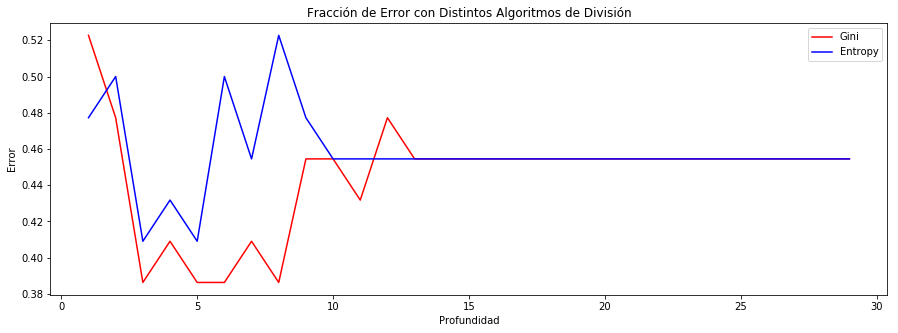

In [36]:
errores_gini = [1.0-train_modelT_gini(profundidad).score(X_pca_test,y_test) for profundidad in depths]
errores_entropy = [1.0-train_modelT_entropy(profundidad).score(X_pca_test,y_test) for profundidad in depths]

plt.figure(figsize=(15,5))
plt.plot(depths, errores_gini, c='r', label='Gini')
plt.plot(depths, errores_entropy, c='b', label='Entropy')
plt.xlabel('Profundidad')
plt.ylabel('Error')
plt.legend(loc='upper right')
plt.title('Fracción de Error con Distintos Algoritmos de División')
plt.show()

El error es altísimo (al rededor del 45% de los datos mal clasificados). Ambos convergen al mismo error, dado que su inicialización es la misma (misma semilla entregada en el parámetro random_state)

# (Comentar respecto a este ítem)

#### (m) Experimentación con distintas cantidad de dimensiones de proyección d usando PCA. Encontrar aquel d que resulte en error menor.

El valor de $d$ puede variar entre 2 y 100000. Primero, se limitará este rango de variación entre 2 y 200. Se usará el algoritmo 'Gini' y 'Entropy' para el entrenamiento del árbol, con una profundidad de 13, pues se cree, en base al desarrollo del ítem anterior, que la convergencia se logrará a esta misma profundidad con una proyección de mayor dimensionalidad.

In [118]:
error_pca_variable_gini = []
error_pca_variable_entropy = []

for d in range(2, 201):
    pca_model = PCA(n_components=d)
    pca_model.fit(X_train)
    X_pca_train = pca_model.transform(X_train)
    X_pca_test = pca_model.transform(X_test)

    error_pca_variable_gini.append(1.0-train_modelT_gini(param=13).score(X_pca_test,y_test))
    error_pca_variable_entropy.append(1.0-train_modelT_entropy(param=13).score(X_pca_test,y_test))
    
    if d%5==0: print('Error con d=%d - Gini: %.3f - Entropy: %.3f' % 
                     (d, error_pca_variable_gini[-1], error_pca_variable_entropy[-1]))

Error con d=5 - Gini: 0.227 - Entropy: 0.182
Error con d=10 - Gini: 0.250 - Entropy: 0.409
Error con d=15 - Gini: 0.205 - Entropy: 0.227
Error con d=20 - Gini: 0.318 - Entropy: 0.295
Error con d=25 - Gini: 0.341 - Entropy: 0.364
Error con d=30 - Gini: 0.341 - Entropy: 0.364
Error con d=35 - Gini: 0.341 - Entropy: 0.409
Error con d=40 - Gini: 0.341 - Entropy: 0.341
Error con d=45 - Gini: 0.364 - Entropy: 0.364
Error con d=50 - Gini: 0.455 - Entropy: 0.455
Error con d=55 - Gini: 0.409 - Entropy: 0.341
Error con d=60 - Gini: 0.386 - Entropy: 0.364
Error con d=65 - Gini: 0.409 - Entropy: 0.341
Error con d=70 - Gini: 0.341 - Entropy: 0.318
Error con d=75 - Gini: 0.409 - Entropy: 0.341
Error con d=80 - Gini: 0.409 - Entropy: 0.318
Error con d=85 - Gini: 0.455 - Entropy: 0.273
Error con d=90 - Gini: 0.341 - Entropy: 0.318
Error con d=95 - Gini: 0.341 - Entropy: 0.364
Error con d=100 - Gini: 0.295 - Entropy: 0.318
Error con d=105 - Gini: 0.364 - Entropy: 0.364
Error con d=110 - Gini: 0.341 - E

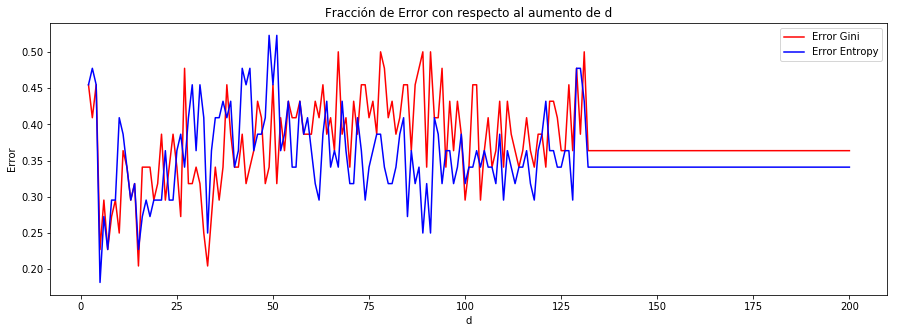

In [119]:
plt.figure(figsize=(15,5))
plt.plot(range(2,201), error_pca_variable_gini, c='r', label='Error Gini')
plt.plot(range(2,201), error_pca_variable_entropy, c='b', label='Error Entropy')
plt.xlabel('d')
plt.ylabel('Error')
plt.legend(loc='upper right')
plt.title('Fracción de Error con respecto al aumento de d')
plt.show()

In [124]:
print("Error minimo - Gini: %.4f - Entropy: %.4f" % (min(error_pca_variable_gini), min(error_pca_variable_entropy)))
print("Valor de d optimo - Gini: %d - Entropy: %d" % (error_pca_variable_gini.index(min(error_pca_variable_gini)), error_pca_variable_entropy.index(min(error_pca_variable_entropy))))

Error minimo - Gini: 0.2045 - Entropy: 0.1818
Valor de d optimo - Gini: 13 - Entropy: 3


In [126]:
error_pca_variable_gini[127:132]

[0.47727272727272729,
 0.38636363636363635,
 0.5,
 0.36363636363636365,
 0.36363636363636365]

In [127]:
error_pca_variable_entropy[127:132]

[0.47727272727272729,
 0.47727272727272729,
 0.43181818181818177,
 0.34090909090909094,
 0.34090909090909094]

El mínimo error se presenta cuando se usa 'Entropy', con $d=3$, y corresponde a $0.\bar{18}$. También se nota que ambos algoritmos convergen en el mismo valor de dimensionalidad, $d=131$.

# Completar análisis

#### (n) Reducción de dimensionalidad con LDA, a d=2 dimensiones.

In [130]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

model_lda = LDA(n_components=2)
model_lda.fit(X_train,y_train)
X_lda_train = model_lda.transform(X_train)
X_lda_test = model_lda.transform(X_test)

c:\program files\python35\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Al ejecutar el bloque de código anterior, se muestra un *warning* que dice: *warnings.warn("Variables are collinear.")*. Esto es que las variables (cada dato de entrenamiento), están correlacionadas, lo que perjudica al momento de calcular la matriz inversa del conjunto de datos $X$, pues se tendrá que $X$ es *cercana* a ser singular. El efecto de esto es que los nuevos datos $(x_1^{LDA}$, $x_2^{LDA})$ generados por LDA no serán *confiables* o estables. Pequeños cambios en la matriz $X$ producirán grandes cambios en los $(x_1^{LDA}$, $x_2^{LDA})$. También, se sobreestimará y/o subestimará el aporte de algunos atributos al momento de generar cada par $(x_1^{LDA}$, $x_2^{LDA})$.


A continuación, se grafica la proyección obtenida, usando la misma leyenda de colores:

0: 'artifact' -> Rojo

1: 'normal/extrahls' -> Verde

2: 'murmur' -> Azul

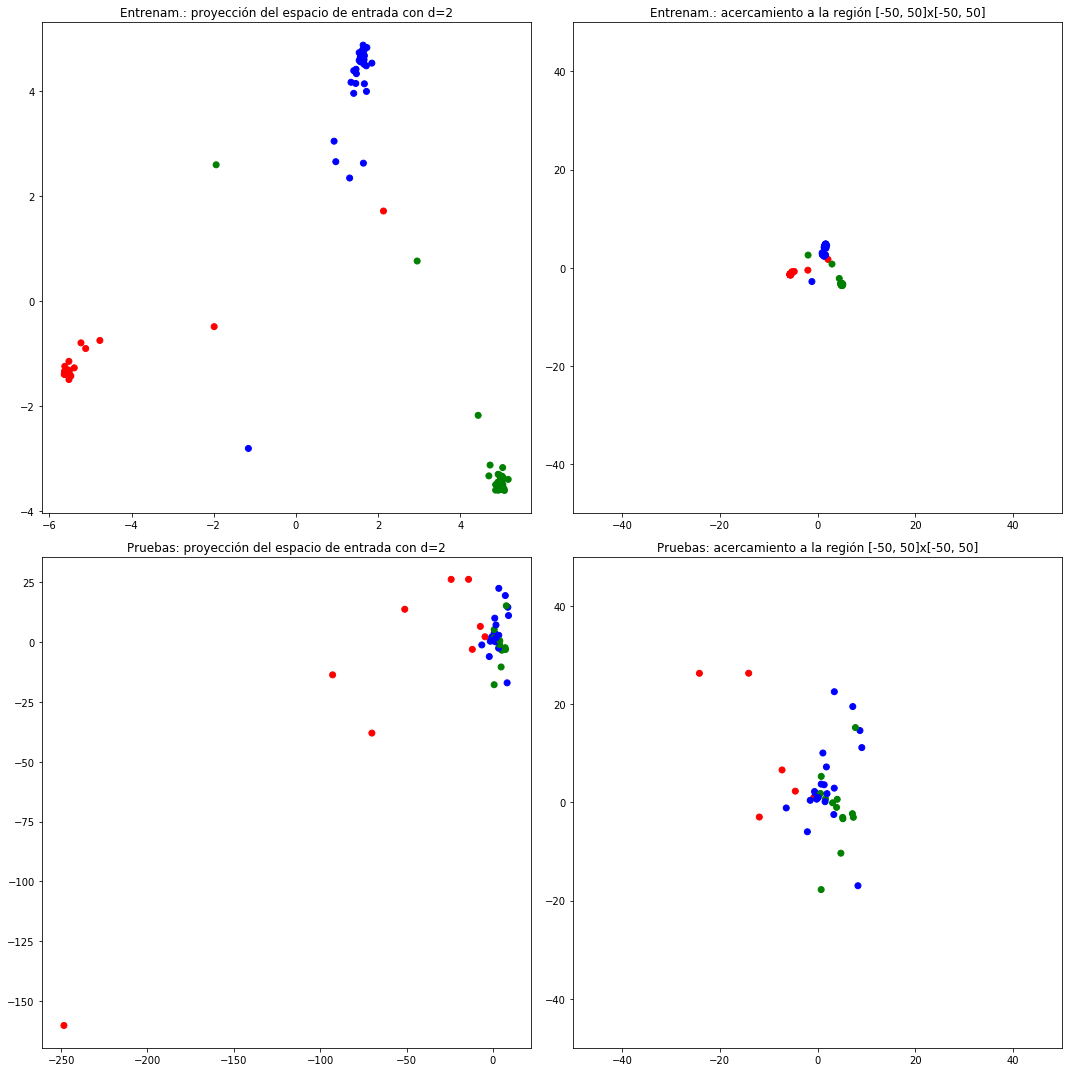

In [132]:
color = {0: "r", 1: "g", 2: "b"}
colores_train = [color[i] for i in y_train]
colores_test = [color[i] for i in y_test]

plt.clf()

f, axarr = plt.subplots(2, 2, figsize=(15,15))
axarr[0][0].scatter(X_lda_train.T[0], X_lda_train.T[1], c=colores_train)
axarr[0][0].set_title('Entrenam.: proyección del espacio de entrada con d=2')
axarr[0][1].scatter(X_lda_train.T[0], X_lda_train.T[1], c=colores_train)
axarr[0][1].set_xlim([-50, 50])
axarr[0][1].set_ylim([-50, 50])
axarr[0][1].set_title('Entrenam.: acercamiento a la región [-50, 50]x[-50, 50]')
axarr[1][0].scatter(X_lda_test.T[0], X_lda_test.T[1], c=colores_test)
axarr[1][0].set_title('Pruebas: proyección del espacio de entrada con d=2')
axarr[1][1].scatter(X_lda_test.T[0], X_lda_test.T[1], c=colores_test)
axarr[1][1].set_xlim([-50, 50])
axarr[1][1].set_ylim([-50, 50])
axarr[1][1].set_title('Pruebas: acercamiento a la región [-50, 50]x[-50, 50]')

plt.tight_layout()

plt.show()

Si bien, el conjunto de entrenamiento se proyecta de manera correcta, el efecto de la colinealidad de los datos se hace evidente cuando se intenta aplicar la misma proyección sobre el conjunto de prueba: las tres clases de datos quedan superpuestas, y algunos de los puntos se alejan mucho del origen. Esto se corresponde con la afirmación de que cambios pequeños en el conjunto de datos generan grandes cambios en la proyección resultante.

#### (o) Repetición de los ítems (h) y (i), usando ahora la proyección de d dimensiones obtenida con LDA.

In [137]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y,
                                                    test_size=0.25, random_state=42)

std = StandardScaler(with_mean=True, with_std=True)
std.fit(X_train)
X_train = std.transform(X_train)
X_test = std.transform(X_test)

model_lda = LDA(n_components=2)
model_lda.fit(X_train,y_train)
X_lda_train = model_lda.transform(X_train)
X_lda_test = model_lda.transform(X_test)

c:\program files\python35\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Se repetirá el ítem (k) y (l):

Se entrena un regresor lineal:

In [141]:
from ipywidgets import interactive

def visualize_border_interactive_lr(param):
    model = train_model_lr(param)
    print ("Error: ", round(1.0-model.score(X_lda_test, y_test), 3))
    visualize_border(model,X_lda_test,y_test)
    
def visualize_border_interactive_svm(param):
    model = train_model_svm(param)
    print ("Error: ", round(1.0-model.score(X_lda_test, y_test), 3))
    visualize_border(model,X_lda_test,y_test)

In [142]:
interactive(visualize_border_interactive_lr, param=Cs)

interactive(children=(Dropdown(description='param', options=(0.0001, 0.01, 0.1, 1, 10, 100, 1000), value=0.0001), Output()), _dom_classes=('widget-interact',))

In [143]:
interactive(visualize_border_interactive_svm, param=Cs)

interactive(children=(Dropdown(description='param', options=(0.0001, 0.01, 0.1, 1, 10, 100, 1000), value=0.0001), Output()), _dom_classes=('widget-interact',))

El rendimiento de la clasificación sobre el conjunto de pruebas es mucho peor que usando PCA. La causa de esto es la colinealidad de los datos $x^l \in X$ de entrada.

A continuación se probará con árboles de clasificación. Uso de algoritmos 'Gini' y 'Entropy'.

In [151]:
def visualize_border_interactiveT_gini(param):
    model = train_modelT_gini(param)
    print ("Error: ", round(1.0-model.score(X_lda_test, y_test), 3))
    visualize_border(model,X_lda_test,y_test)

interactive(visualize_border_interactiveT_gini,param=depths)

interactive(children=(Dropdown(description='param', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29), value=1), Output()), _dom_classes=('widget-interact',))

In [152]:
def visualize_border_interactiveT_entropy(param):
    model = train_modelT_entropy(param)
    print ("Error: ", round(1.0-model.score(X_lda_test, y_test), 3))
    visualize_border(model,X_lda_test,y_test)

interactive(visualize_border_interactiveT_entropy,param=depths)

interactive(children=(Dropdown(description='param', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29), value=1), Output()), _dom_classes=('widget-interact',))

Comparación de error en función de la profundidad:

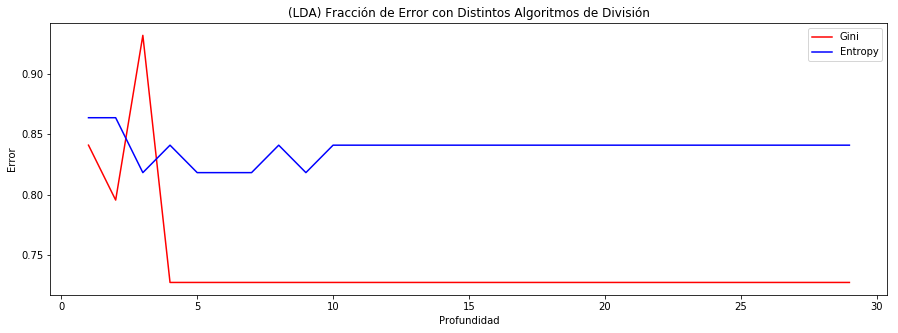

In [153]:
errores_gini = [1.0-train_modelT_gini(profundidad).score(X_lda_test,y_test) for profundidad in depths]
errores_entropy = [1.0-train_modelT_entropy(profundidad).score(X_lda_test,y_test) for profundidad in depths]

plt.figure(figsize=(15,5))
plt.plot(depths, errores_gini, c='r', label='Gini')
plt.plot(depths, errores_entropy, c='b', label='Entropy')
plt.xlabel('Profundidad')
plt.ylabel('Error')
plt.legend(loc='upper right')
plt.title('(LDA) Fracción de Error con Distintos Algoritmos de División')
plt.show()

In [154]:
print("Error minimo - Gini: %.4f - Entropy: %.4f" % (min(errores_gini), min(errores_entropy)))
print("Profunidad optima - Gini: %d - Entropy: %d" % (errores_gini.index(min(errores_gini)), errores_entropy.index(min(errores_entropy))))

Error minimo - Gini: 0.7273 - Entropy: 0.8182
Profunidad optima - Gini: 3 - Entropy: 2


Por lo tanto, se nota que los modelos se desempeñan peor usando LDA. Como se dijo anteriormente, LDA combina todos los atributos para producir $d=2$, que son la proyección. El supuesto que se tiene que cumplir para el buen funcionamiento de LDA es que los datos de entrada (las filas de la matriz $X$) sean linealmente independientes, lo que no se cumple. Por lo tanto, los $d$ atributos de la proyección se comportarán de manera inesperada respecto a cambios en la matriz de entrada $X$. En este caso, el cambio producido en $X$ es que se cambió el conjunto de entrenamiento por el de pruebas. Si bien, la proyección ajustada al conjunto de entrenamiento resulta ser *correcta* en el sentido que separa de manera aceptable las clases, esta misma proyección entrega resultados completamente distintos a una separación aceptable, cuando se le entregó la matriz de datos de prueba.

Esta *mala* proyección impidió a los modelos lineales usados lograr buenos resultados.

Con PCA ocurrió algo similar, pero en menor medida. PCA requiere que los atributos (columnas de $X$) sean linealmente independientes. Esto no es así, por lo tanto también ocurrió el problema descrito para LDA. A pesar de esto, se observó que el rendimiento de los modelos sobre los datos proyectados usando PCA fue mejor que usando LDA, ya que quizás la dependencia lineal de los atributos (columnas) no era tan marcada como la de los datos (filas).

#### (o) Diseño de características a partir de las secuencias de amplitudes (datos brutos) para mejorar el rendimiento de los modelos clasificadores ya entrenados.

Se usará el método de la referencia número 6 del enunciado de la tarea. Cada uno de las series de amplitudes se transformará a un vector de estadísticos relevantes:


1. meanfreq: mean frequency (in kHz)

2. sd: standard deviation of frequency

3. median: median frequency (in kHz)

4. Q25: first quantile (in kHz)

5. Q75: third quantile (in kHz)

6. IQR: interquantile range (in kHz)

7. skew: skewness (see note in specprop description)

8. kurt: kurtosis (see note in specprop description)

9. sp.ent: spectral entropy

10. sfm: spectral flatness

11. mode: mode frequency

12. centroid: frequency centroid (see specprop)

13. peakf: peak frequency (frequency with highest energy)

14. meanfun: average of fundamental frequency measured across acoustic signal

15. minfun: minimum fundamental frequency measured across acoustic signal

16. maxfun: maximum fundamental frequency measured across acoustic signal

17. meandom: average of dominant frequency measured across acoustic signal

18. mindom: minimum of dominant frequency measured across acoustic signal

19. maxdom: maximum of dominant frequency measured across acoustic signal

20. dfrange: range of dominant frequency measured across acoustic signal

21. modindx: modulation index. Calculated as the accumulated absolute 
difference between adjacent measurements of fundamental frequencies divided 
by the frequency range

y: label: 0 (artifact), 1 (normal/extrahls), 2 (murmur)

# Completar. ¡Buscar forma de generar los estadísticos automáticamente!